# Compneuro workshop 2021

## Tutorial 2 - Autoencoders
#### Creator: Manos Theodosis

---

## Tutorial objectives

In this notebook we will learn a few things about autoencoders
- Implement a linear autoencoder and contrast it with PCA.
- Implement a nonlinear (and sparse) autoencoder.
- Implement a deep autoencoder.
- Compare the different autoencoders.

---
## Imports and helper functtions

Execute the following cells that import packages needed for this notebook.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.set_cmap("gray")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchsummary

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.utils import make_grid, save_image
import torchvision.datasets as ds

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<Figure size 432x288 with 0 Axes>

In [2]:
def load_mnist(datadir="./data_cache"):
    train_ds = ds.MNIST(root=datadir, train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
    test_ds = ds.MNIST(root=datadir, train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
    def to_xy(dataset):
        Y = dataset.targets.long()
        X = dataset.data.view(dataset.data.shape[0], -1) / 255.0
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    mean = X_tr.mean(dim=0)
    X_tr -= mean
    X_te -= mean
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128, num_workers=4):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)

## Exercise 1: Linear autoencoders

As we've seen, autoencoders map us from the data domain to a latent representation. For this exercise, we will create a linear autoencoder and we will compare the latent representation with that of PCA.

### 1.1 Create the `LinearAutoencoder` class
In the next cell, fill in the code for the linear autoencoder.

**Note**: for this class, we will not include learnable biases in the linear layers, in order to be able to compare and contrast with PCA. Feel free to experiment with adding biases to this class, or removing them from the rest of the classes we will create.

In [3]:
class LinearAutoencoder(nn.Module):
    def __init__(
        self,
        input_size,
        latent_size,
    ):
        super(LinearAutoencoder, self).__init__()

        self.input_size = input_size
        self.latent_size = latent_size
        
        # create the encoder and the decoder
        self.encoder = nn.Linear(self.input_size, self.latent_size, bias=False)
        self.decoder = nn.Linear(self.latent_size, self.input_size, bias=False)

    def forward(self, data):
        # encode the input to the latent space
        latent = self.encoder(data)
        
        # decode the latent representation back into the input space
        recons = self.decoder(latent)
        return recons

### 1.2 Load MNIST
Let's load MNIST using the provided `load_mnist()` function and keep $5,000$ images to train our autoencoder. When creating data loaders, use a batch size of $256$ (to make training faster). Let's also visualize some of the data to see what they look like.

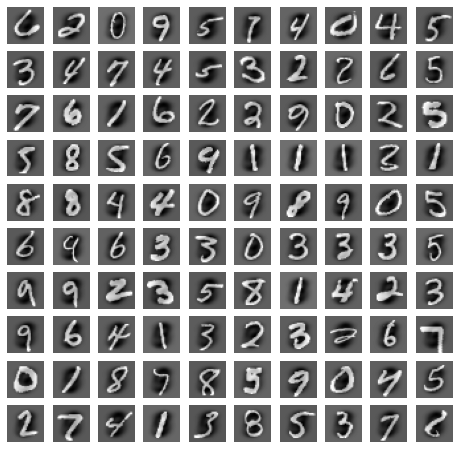

In [4]:
# load MNIST and keep a subset
X_tr, Y_tr, X_te, Y_te = load_mnist()

num_train = 5000
indexes = np.random.choice(len(X_tr), num_train, replace=False)

X_tr = X_tr[indexes]
Y_tr = Y_tr[indexes]

# generate loaders
batch_size = 256
train_dl = make_loader(TensorDataset(X_tr, Y_tr), batch_size=batch_size)
test_dl = make_loader(TensorDataset(X_te, Y_te), batch_size=batch_size)

# plot some of the data
indexes_train = np.random.choice(len(X_tr), 100, replace=False)
fig, axes = plt.subplots(10, 10, figsize=(8,8))

idx = 0
for row in axes:
    for col in row:
        img = X_tr[indexes_train[idx]].reshape(28,28)
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

### 1.3 Create a model
We will now create a model from the `LinearAutoencoder` class that we defined, and we'll print the summary in order to get a sense of how many parameters it has.

In [5]:
input_size = 784
latent_size = 100
model = LinearAutoencoder(input_size, latent_size).to(device)

In [6]:
torchsummary.summary(model, (1, 1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 100]          78,400
            Linear-2            [-1, 1, 1, 784]          78,400
Total params: 156,800
Trainable params: 156,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.60
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


### 1.4 Train the model
We are now able to train the model we created. We will train using the `MSELoss()` for $20$ epochs, using a learning rate of $0.001$.

In [7]:
num_epochs = 20
lr = 1e-3

opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch}')
    
    # training phase
    model.train()
    net_loss = 0.0
    n_total = 0
    for x, _ in tqdm(train_dl):
        x = x.to(device)
        
        # pass the data through the model
        out = model(x)
        loss = loss_func(x, out)
        
        # backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # keep loss statistics
        net_loss += loss.item() * len(x)
        n_total += len(x)
    train_loss = net_loss / n_total

    # evaluation phase
    model.eval()
    net_loss = 0.0
    n_total = 0
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_dl):
            x = x.to(device)

            # pass the data through the model
            out = model(x)
            loss = loss_func(x, out)
            
            # keep loss statistics
            net_loss += loss.item() * len(x)
            n_total += len(x)
        test_loss = net_loss / n_total
    print(f'Epoch {epoch}:\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Starting Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:	 Train Loss: 0.060	 Test Loss: 0.045
Starting Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:	 Train Loss: 0.038	 Test Loss: 0.031
Starting Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2:	 Train Loss: 0.027	 Test Loss: 0.024
Starting Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:	 Train Loss: 0.022	 Test Loss: 0.019
Starting Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:	 Train Loss: 0.018	 Test Loss: 0.016
Starting Epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:	 Train Loss: 0.016	 Test Loss: 0.014
Starting Epoch 6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:	 Train Loss: 0.014	 Test Loss: 0.013
Starting Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:	 Train Loss: 0.013	 Test Loss: 0.012
Starting Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:	 Train Loss: 0.012	 Test Loss: 0.011
Starting Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:	 Train Loss: 0.011	 Test Loss: 0.010
Starting Epoch 10


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:	 Train Loss: 0.010	 Test Loss: 0.010
Starting Epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:	 Train Loss: 0.009	 Test Loss: 0.009
Starting Epoch 12


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12:	 Train Loss: 0.009	 Test Loss: 0.009
Starting Epoch 13


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:	 Train Loss: 0.009	 Test Loss: 0.008
Starting Epoch 14


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:	 Train Loss: 0.008	 Test Loss: 0.008
Starting Epoch 15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:	 Train Loss: 0.008	 Test Loss: 0.008
Starting Epoch 16


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:	 Train Loss: 0.008	 Test Loss: 0.008
Starting Epoch 17


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:	 Train Loss: 0.008	 Test Loss: 0.008
Starting Epoch 18


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:	 Train Loss: 0.007	 Test Loss: 0.007
Starting Epoch 19


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 19:	 Train Loss: 0.007	 Test Loss: 0.007


### 1.5 Visualize the ouputs
We have now trained our model and we are able to visualize its various outputs. We will focus on three things:
- We want to visualize the filters/weights that the network is learning.
- We want to visualize the latent representations of the data.
- We want to visualize the reconstruction, to make sure the network is working.

Fill in the code in the following three cells to generate the corresponding visualizations.

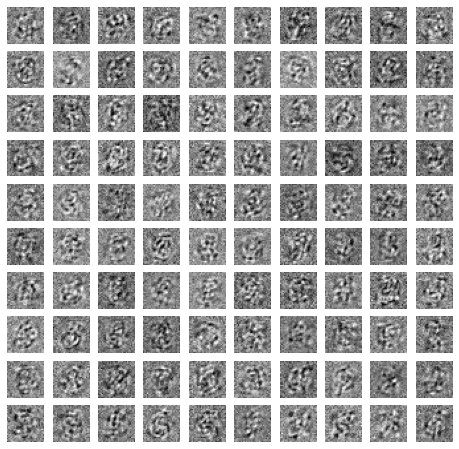

In [8]:
# visualize weights
fig, axes = plt.subplots(10, 10, figsize=(8,8))

idx = 0
for row in axes:
    for col in row:
        img = model.encoder.weight[idx, :].reshape(28, 28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

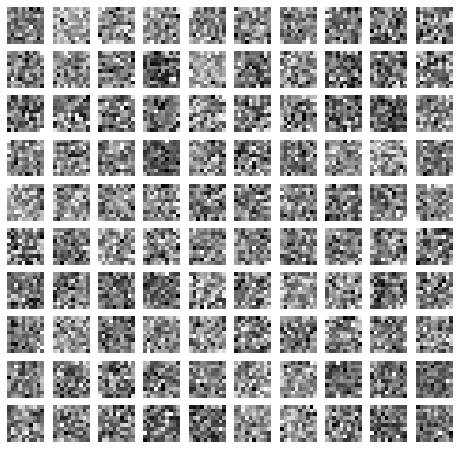

In [9]:
# visualize latents
fig, axes = plt.subplots(10, 10, figsize=(8,8))
model_enc = model.encoder(X_te)
indexes_test = np.random.choice(len(X_te), 100, replace=False)

idx = 0
for row in axes:
    for col in row:
        img = model_enc[indexes_test[idx]].reshape(10,10).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

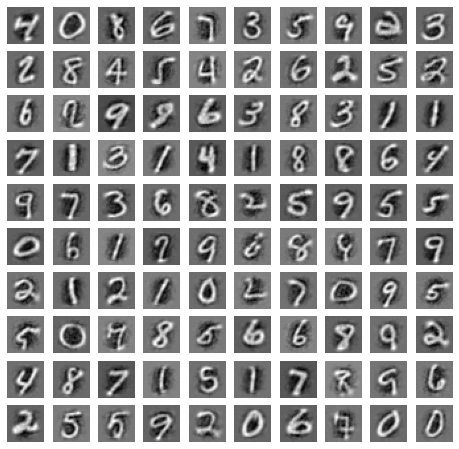

In [10]:
# visualize reconstructions
fig, axes = plt.subplots(10, 10, figsize=(8,8))
model_test = model(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(28,28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

### 1.6 Compare reconstructions with those of PCA
Since autoencoders are unsupervised techniques that can help in dimensionality reduction, it is natural to compare them with PCA. Run PCA below using `scikit-learn` and plot the reconstructions in order to compare them with the reconstructions of our autoencoder.

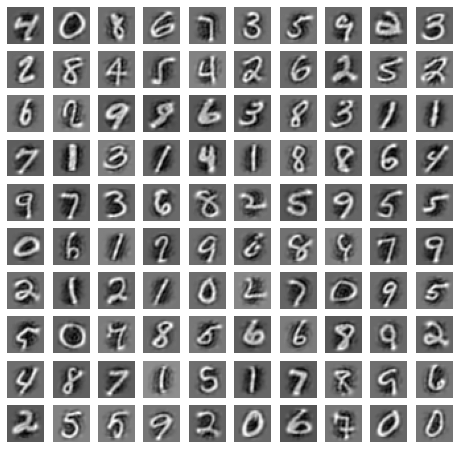

In [11]:
# run PCA on the training data
pca = PCA(n_components=100)
pca.fit(X_tr)

# evaluate on the test data
pca_test = pca.transform(X_te)
inv_test = pca.inverse_transform(pca_test)

# plot the reconstructions
fig, axes = plt.subplots(10, 10, figsize=(8,8))

idx = 0
for row in axes:
    for col in row:
        img = inv_test[indexes_test[idx]].reshape(28,28)
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

It turns out that _linear_ autoencoders learn the principal components of the data, and are equivalent with PCA. In the following, we will start experimenting with _nonlinear_ autoencoders.

## Exercise 2: Nonlinear autoencoders
Since linear autoencoders are learning the principal components of the data, we will introduce nonlinearities to allow our models to be more expressive.

### 2.1 Create the `NonLinearAutoencoder` class
In the next cell, fill in the code for the nonlinear autoencoder.

**Note**: feel free to experiment with other nonlinearities (e.g. `PReLU`, `tanh`, `sigmoid` or others from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html)) and report your findings. Do all of them work equally well?

In [12]:
class NonLinearAutoencoder(nn.Module):
    def __init__(
        self,
        input_size,
        latent_size,
    ):
        super(NonLinearAutoencoder, self).__init__()

        self.input_size = input_size
        self.latent_size = latent_size
    
        # create the encoder and the decoder
        self.encoder = nn.Linear(self.input_size, self.latent_size)
        self.decoder = nn.Linear(self.latent_size, self.input_size)
            
    def forward(self, data):
        # encode the input to the latent space
        latent = F.relu(self.encoder(data))
        
        # decode the latent representation back into the input space
        recons = F.relu(self.decoder(latent))
        
        # output the latent representation too so we can use it for sparsity
        return recons, latent

### 2.2 Create the model
Create now an model from the `NonLinearAutoencoder` class and print it's summary. Since the only thing we changed is that we added nonlinearities, we expect the number of parameters to be the same.

In [13]:
input_size = 784
latent_size = 100
model2 = NonLinearAutoencoder(input_size, latent_size).to(device)

torchsummary.summary(model2, (1, 1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 100]          78,500
            Linear-2            [-1, 1, 1, 784]          79,184
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.60
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


### 2.3 Train the model
Let's now train the model using the same parameters as before.

In [14]:
num_epochs = 20
lr = 1e-3

opt = torch.optim.Adam(model2.parameters(), lr=lr)
loss_func = nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch}')
    
    # training phase
    model2.train()
    net_loss = 0.0
    n_total = 0
    for x, _ in tqdm(train_dl):
        x = x.to(device)

        # pass the data through the model
        out, _ = model2(x)
        loss = loss_func(x, out)
        
        # backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # keep loss statistics
        net_loss += loss.item() * len(x)
        n_total += len(x)
    train_loss = net_loss / n_total

    # evaluation phase
    model2.eval()
    net_loss = 0.0
    n_total = 0
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_dl):
            x = x.to(device)

            # pass the data through the model
            out, _ = model2(x)
            loss = loss_func(x, out)
            
            # keep loss statistics
            net_loss += loss.item() * len(x)
            n_total += len(x)
        test_loss = net_loss / n_total
    print(f'Epoch {epoch}:\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Starting Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:	 Train Loss: 0.064	 Test Loss: 0.057
Starting Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:	 Train Loss: 0.053	 Test Loss: 0.048
Starting Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2:	 Train Loss: 0.046	 Test Loss: 0.043
Starting Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:	 Train Loss: 0.042	 Test Loss: 0.040
Starting Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:	 Train Loss: 0.039	 Test Loss: 0.038
Starting Epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:	 Train Loss: 0.037	 Test Loss: 0.036
Starting Epoch 6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:	 Train Loss: 0.036	 Test Loss: 0.035
Starting Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:	 Train Loss: 0.035	 Test Loss: 0.034
Starting Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:	 Train Loss: 0.034	 Test Loss: 0.034
Starting Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:	 Train Loss: 0.033	 Test Loss: 0.033
Starting Epoch 10


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:	 Train Loss: 0.033	 Test Loss: 0.033
Starting Epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:	 Train Loss: 0.032	 Test Loss: 0.032
Starting Epoch 12


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12:	 Train Loss: 0.032	 Test Loss: 0.032
Starting Epoch 13


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:	 Train Loss: 0.032	 Test Loss: 0.032
Starting Epoch 14


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:	 Train Loss: 0.031	 Test Loss: 0.031
Starting Epoch 15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:	 Train Loss: 0.031	 Test Loss: 0.031
Starting Epoch 16


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:	 Train Loss: 0.031	 Test Loss: 0.031
Starting Epoch 17


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:	 Train Loss: 0.030	 Test Loss: 0.031
Starting Epoch 18


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:	 Train Loss: 0.030	 Test Loss: 0.030
Starting Epoch 19


100%|██████████| 20/20 [00:00<00:00, 24.09it/s]


Epoch 19:	 Train Loss: 0.030	 Test Loss: 0.030


### 2.4 Visualize the ouputs
As before, let's visualize the weights, latent representations, and reconstructions.

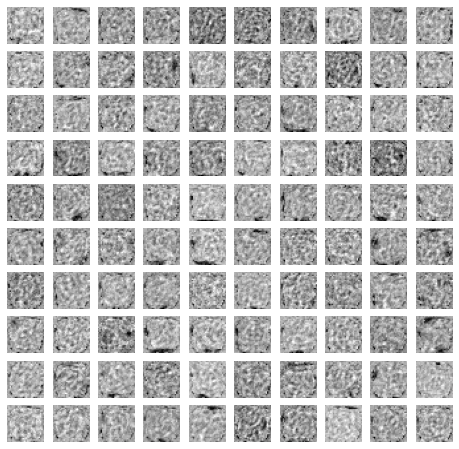

In [15]:
# visualize weights
fig, axes = plt.subplots(10, 10, figsize=(8,8))

idx = 0
for row in axes:
    for col in row:
        img = model2.encoder.weight[idx, :].reshape(28, 28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

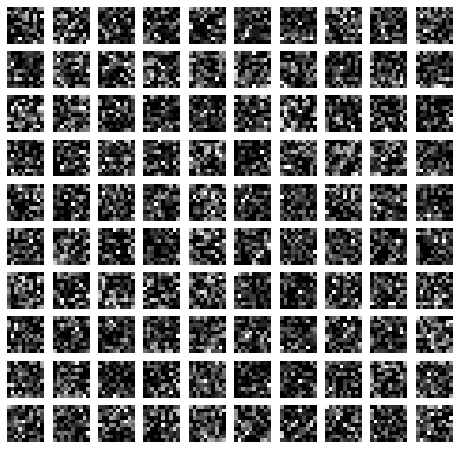

In [16]:
# visualize latents
fig, axes = plt.subplots(10, 10, figsize=(8,8))
_, model_test = model2(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(10,10).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

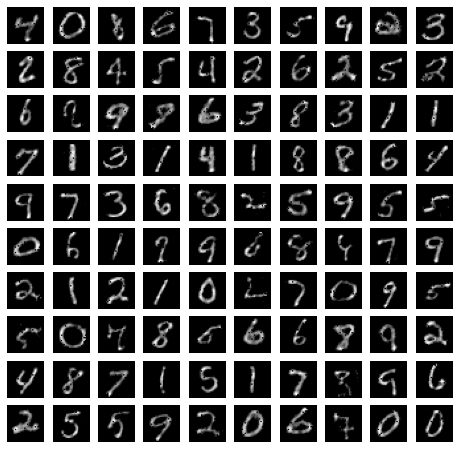

In [17]:
#visualize reconstructions
fig, axes = plt.subplots(10, 10, figsize=(8,8))
model_test, _ = model2(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(28,28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

Our latent representations look a bit sparser than before, but the weights the network is learning are still not very interpretable. Let's try adding sparsity on the codes in order to enforce the autoencoder to learn more interpretable features.

### 2.4 Train with a sparse objective
Modify your training procedure from before to include a sparsity penalty. Set the regularization parameter `lam = 0.00125`.

**Note**: feel free to experiment with different values of `lam`. How does increasing this parameter affects the latent representations and the weights? What about decreasing it? Are the reconstructions still acceptable?

In [18]:
num_epochs = 20
lr = 1e-3
lam = 0.00125

model2 = NonLinearAutoencoder(input_size, latent_size).to(device)

opt = torch.optim.Adam(model2.parameters(), lr=lr)
loss_func = nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch}')
    
    # training phase
    model2.train()
    net_loss = 0.0
    n_total = 0
    for x, _ in tqdm(train_dl):
        x = x.to(device)

        # pass the data through the model
        out, code = model2(x)
        loss = loss_func(x, out) + lam * torch.mean(torch.sum(torch.abs(code), dim=-1))
        
        # backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # keep loss statistics
        net_loss += loss.item() * len(x)
        n_total += len(x)
    train_loss = net_loss / n_total

    # evaluation phase
    model2.eval()
    net_loss = 0.0
    n_total = 0
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_dl):
            x = x.to(device)

            # pass the data through the model
            out, code = model2(x)
            loss = loss_func(x, out) + lam * torch.mean(torch.sum(torch.abs(code), dim=-1))
            
            # keep loss statistics
            net_loss += loss.item() * len(x)
            n_total += len(x)
        test_loss = net_loss / n_total
    print(f'Epoch {epoch}:\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Starting Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:	 Train Loss: 0.072	 Test Loss: 0.069
Starting Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:	 Train Loss: 0.066	 Test Loss: 0.064
Starting Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2:	 Train Loss: 0.062	 Test Loss: 0.059
Starting Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:	 Train Loss: 0.058	 Test Loss: 0.056
Starting Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:	 Train Loss: 0.055	 Test Loss: 0.053
Starting Epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:	 Train Loss: 0.052	 Test Loss: 0.051
Starting Epoch 6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:	 Train Loss: 0.050	 Test Loss: 0.049
Starting Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:	 Train Loss: 0.049	 Test Loss: 0.048
Starting Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:	 Train Loss: 0.048	 Test Loss: 0.047
Starting Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:	 Train Loss: 0.047	 Test Loss: 0.046
Starting Epoch 10


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:	 Train Loss: 0.046	 Test Loss: 0.045
Starting Epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:	 Train Loss: 0.045	 Test Loss: 0.045
Starting Epoch 12


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12:	 Train Loss: 0.044	 Test Loss: 0.044
Starting Epoch 13


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:	 Train Loss: 0.044	 Test Loss: 0.044
Starting Epoch 14


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:	 Train Loss: 0.043	 Test Loss: 0.043
Starting Epoch 15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:	 Train Loss: 0.043	 Test Loss: 0.043
Starting Epoch 16


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:	 Train Loss: 0.043	 Test Loss: 0.043
Starting Epoch 17


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:	 Train Loss: 0.042	 Test Loss: 0.043
Starting Epoch 18


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:	 Train Loss: 0.042	 Test Loss: 0.042
Starting Epoch 19


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


Epoch 19:	 Train Loss: 0.042	 Test Loss: 0.042


### 2.5 Visualize the outputs
As before, visualize the outputs of the network.

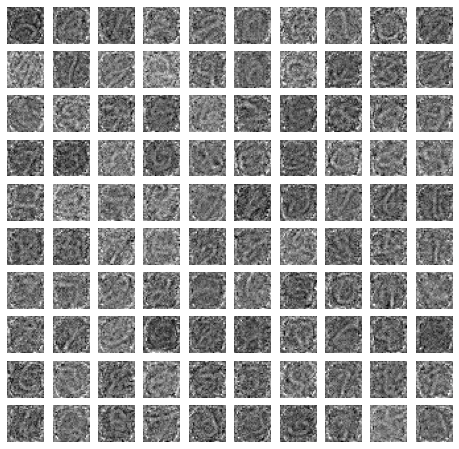

In [19]:
# visualize weights
fig, axes = plt.subplots(10, 10, figsize=(8,8))

idx = 0
for row in axes:
    for col in row:
        img = model2.encoder.weight[idx, :].reshape(28, 28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

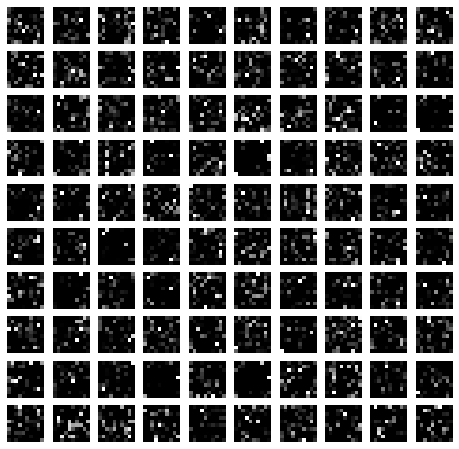

In [20]:
# visualize latents
fig, axes = plt.subplots(10, 10, figsize=(8,8))
_, model_test = model2(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(10,10).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

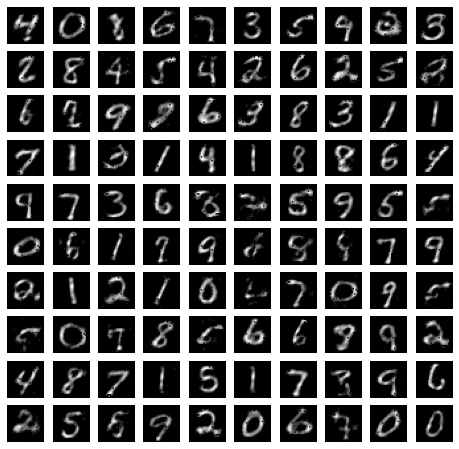

In [21]:
#visualize reconstructions
fig, axes = plt.subplots(10, 10, figsize=(8,8))
model_test, _ = model2(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(28,28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

We can see that the latent representations are significantly sparser now and the filters are starting to look a little bit more like digits, and the reconstructions are still reasonable. For the final part, let's make a deep autoencoder.

## Exercise 3: Deep autoencoders
Let's examine how the depth of the autoencoder affects

### 3.1 Create the `DeepAutoencoder` class
In the next cell, fill in the code for the deep autoencoder.

In [22]:
class DeepAutoencoder(nn.Module):
    def __init__(
        self,
        input_size,
        firstlayer_size,
        seconlayer_size,
        thirdlayer_size,
    ):
        super(DeepAutoencoder, self).__init__()

        self.input_size = input_size
        self.firstlayer_size = firstlayer_size
        self.seconlayer_size = seconlayer_size
        self.thirdlayer_size = thirdlayer_size
    
        # create the encoder and the decoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, self.firstlayer_size),
            nn.ReLU(),
            nn.Linear(self.firstlayer_size, self.seconlayer_size),
            nn.ReLU(),
            nn.Linear(self.seconlayer_size, self.thirdlayer_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.thirdlayer_size, self.seconlayer_size),
            nn.ReLU(),
            nn.Linear(self.seconlayer_size, self.firstlayer_size),
            nn.ReLU(),
            nn.Linear(self.firstlayer_size, self.input_size),
            nn.ReLU(),
        )
            
    def forward(self, data):
        # encode the input to the latent space
        latent = self.encoder(data)
        
        # decode the latent representation back into the input space
        recons = self.decoder(latent)
        
        # output the latent representation too so we can use it for sparsity
        return recons, latent

### 3.2 Train with a sparse objective
We will train the deep autoencoder directly using a sparse objective. Create a model from the `DeepAutoencoder` class with $400$, $200$, and $100$ sizes for the intermediate layers. Set the regularization parameter `lam = 0.00005` and use the same parameters as before for training.

In [23]:
num_epochs = 20
lr = 1e-3
lam = 0.00005

input_size = 784
firstlayer_size = 400
seconlayer_size = 200
thirdlayer_size = 100
model3 = DeepAutoencoder(input_size, firstlayer_size, seconlayer_size, thirdlayer_size)

opt = torch.optim.Adam(model3.parameters(), lr=lr)
loss_func = nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch}')
    
    # training phase
    model3.train()
    net_loss = 0.0
    n_total = 0
    for x, _ in tqdm(train_dl):
        x = x.to(device)

        # pass the data through the model
        out, code = model3(x)
        loss = loss_func(x, out) + lam * torch.mean(torch.sum(torch.abs(code), dim=-1))
        
        # backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()

        # keep loss statistics
        net_loss += loss.item() * len(x)
        n_total += len(x)
    train_loss = net_loss / n_total

    # evaluation phase
    model3.eval()
    net_loss = 0.0
    n_total = 0
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_dl):
            x = x.to(device)

            # pass the data through the model
            out, code = model3(x)
            loss = loss_func(x, out) + lam * torch.mean(torch.sum(torch.abs(code), dim=-1))
            
            # keep loss statistics
            net_loss += loss.item() * len(x)
            n_total += len(x)
        test_loss = net_loss / n_total
    print(f'Epoch {epoch}:\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Starting Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:	 Train Loss: 0.067	 Test Loss: 0.064
Starting Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:	 Train Loss: 0.061	 Test Loss: 0.058
Starting Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2:	 Train Loss: 0.057	 Test Loss: 0.055
Starting Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3:	 Train Loss: 0.054	 Test Loss: 0.053
Starting Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4:	 Train Loss: 0.052	 Test Loss: 0.051
Starting Epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5:	 Train Loss: 0.051	 Test Loss: 0.050
Starting Epoch 6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6:	 Train Loss: 0.050	 Test Loss: 0.049
Starting Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7:	 Train Loss: 0.048	 Test Loss: 0.048
Starting Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8:	 Train Loss: 0.048	 Test Loss: 0.047
Starting Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9:	 Train Loss: 0.047	 Test Loss: 0.047
Starting Epoch 10


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10:	 Train Loss: 0.046	 Test Loss: 0.046
Starting Epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11:	 Train Loss: 0.046	 Test Loss: 0.046
Starting Epoch 12


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12:	 Train Loss: 0.046	 Test Loss: 0.046
Starting Epoch 13


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13:	 Train Loss: 0.045	 Test Loss: 0.045
Starting Epoch 14


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14:	 Train Loss: 0.045	 Test Loss: 0.045
Starting Epoch 15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15:	 Train Loss: 0.045	 Test Loss: 0.045
Starting Epoch 16


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16:	 Train Loss: 0.044	 Test Loss: 0.044
Starting Epoch 17


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17:	 Train Loss: 0.044	 Test Loss: 0.044
Starting Epoch 18


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18:	 Train Loss: 0.044	 Test Loss: 0.044
Starting Epoch 19


100%|██████████| 20/20 [00:01<00:00, 14.26it/s]


Epoch 19:	 Train Loss: 0.044	 Test Loss: 0.044


### 3.3 Visualize the ouputs
As before, let's visualize the weights, latent representations, and reconstructions.

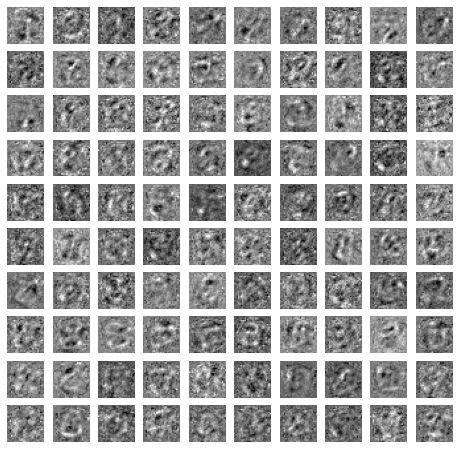

In [24]:
# visualize weights
fig, axes = plt.subplots(10, 10, figsize=(8,8))
weights = model3.encoder[4].weight @ model3.encoder[2].weight @ model3.encoder[0].weight

idx = 0
for row in axes:
    for col in row:
        img = weights[idx, :].reshape(28, 28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

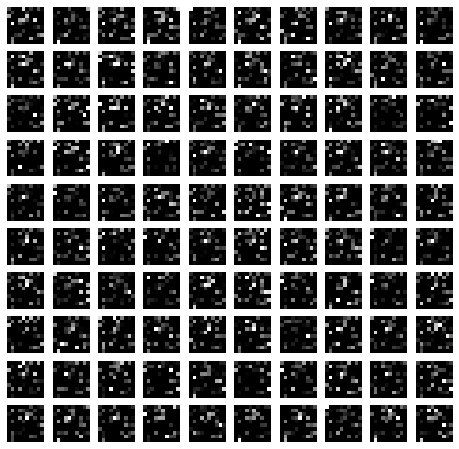

In [25]:
# visualize latents
fig, axes = plt.subplots(10, 10, figsize=(8,8))
_, model_test = model3(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(10,10).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

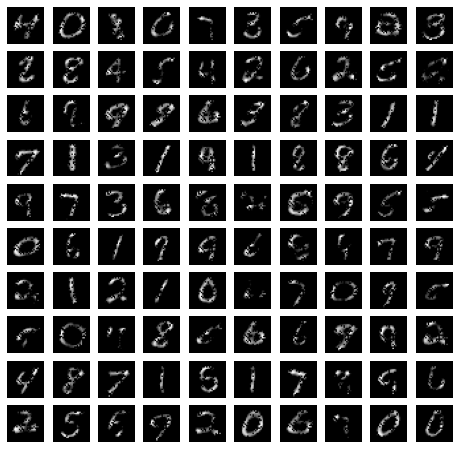

In [26]:
# visualize reconstructions
fig, axes = plt.subplots(10, 10, figsize=(8,8))
model_test, _ = model3(X_te)

idx = 0
for row in axes:
    for col in row:
        img = model_test[indexes_test[idx]].reshape(28,28).detach().numpy()
        col.imshow(img)
        col.axis("off")
        idx += 1
plt.show()

We can see that the weights that we are learning right now look more aggresively like digits (albeit, still, very noisy).

# Wrap-up

In this notebook we learned about training autoencoders, and we examined different trade-offs as we are adding nonlinearities, sparsity, and depth.